# 3) Reconstruct target file with source collection frames

This is the final notebook of the Freesound AMPLAB session and contains the code that performs *audio mosaicing* to construct a new version of the target file by using audio frames chosen from the source collection. This notebook used the DataFrames generated in the previous notebooks which contain metadata about the Freesound sounds in the source collection, the analysis results of the source collection and the analysis results of the target audio file.

In [70]:
import os
import pandas as pd
import essentia
import essentia.standard as estd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from IPython.display import display, Audio
from sklearn import preprocessing
import random

In [71]:
# Load all DataFrames created in the previous notebooks
DATASET_FILENAME = 'dataframe.csv'
DATAFRAME_SOURCE_UNITS_FILENAME = 'dataframe_source.csv'
DATAFRAME_TARGET_FILE_FILENAME = 'dataframe_target.csv'

df = pd.read_csv(open(DATASET_FILENAME), index_col=0)
df_source = pd.read_csv(open(DATAFRAME_SOURCE_UNITS_FILENAME), index_col=0)
df_target = pd.read_csv(open(DATAFRAME_TARGET_FILE_FILENAME), index_col=0)

In [72]:
# Define some util functions
# NOTE: remember that if you update these util functions and want to do a new audio mosaicing, you'll need 
# to re-run both this cell (to update the util functions) and the cell below (which uses the util functions to
# do the audio mosaicing).

loaded_audio_files = {}
selected_frames = {}

def get_audio_file_segment(file_path, start_sample, n_samples):
    """Load audio file. Try to get it from memory first. If not there, open it and save in memory for next time.
    """
    if file_path not in loaded_audio_files:
        loader = estd.MonoLoader(filename=file_path)
        audio = loader()
        loaded_audio_files[file_path] = audio
    else:
        audio = loaded_audio_files[file_path]
        
    # Return segment
    return audio[start_sample:start_sample + n_samples]

def find_similar_frames(query_frame, df_source_frames, n, features):
    """Find the 'n' mosr similar frames for a given 'query_frame' from those in the given 'df_source_frames'.
    Similarity is computed using a nearest neighbors algorithm and taking only into account the feature list
    given in the 'features' parameter.
    """

    query_frame = query_frame.reshape(1,-1)
    nbrs = NearestNeighbors(n_neighbors=n, algorithm='ball_tree').fit(df_source_frames[features].values)
    distances, indices = nbrs.kneighbors(query_frame)
    return [df_source_frames.iloc[k] for k in indices[0]]

def chose_frame_from_source_collection(target_frame, df_source_frames):
    """Choose one frame from 'df_source_frames' to replace the 'target_frame'.
    This implementation chooses the source frame usinng a similarity algorithm 'find_similar_frames',
    and a specific set of similarity features for timbre (MFCC).
    You can modify this function to implement new ways to choose a frame from the source.
    
    NOTE: 'target_frame' here should have the same features as 'df_source_frames' because both the
    target file and the source collection have been analyzed with the same analysis function.
    You can list available features using 'print(list(target_frame.keys()))' and print(list(df_source_frames.keys()))
    """
    n_neighbors_to_find = 10
    similarity_features = [
        'mfcc_0',
        'mfcc_1',
        'mfcc_2',
        'mfcc_3',
        'mfcc_4',
        'mfcc_5',
        'key_strength',
        'key',
        'scale',
        'zero_crossing_rate',
        'f0'
    ]
    # Find the 10 most similar frames to the target_frame from df_source_framesdf_source_units 
    query_frame = target_frame[similarity_features].values
    similar_frames = find_similar_frames(query_frame, df_source_frames, n_neighbors_to_find, similarity_features)
     
#      # return the most similar frame unless it's already been used
#     used_frame_index = 0
#     while(used_frame_index < n_neighbors_to_find):
#         selected_frame = similar_frames[used_frame_index]    
#         if(selected_frame['id'] not in selected_frames):
#             break
#         else:
#             used_frame_index = used_frame_index + 1
    
#     selected_frames[selected_frame['id']] = 1
    selected_frame = similar_frames[0]
    return selected_frame # return the most similar frame
    

In [73]:
# Do the reconstruction (audio mosaicing) of the target file using audio chunks (units, frames) from the sounds in the source collection

# Load target audio file to get its total length and to use it later
target_sound_filename = df_target.iloc[0]['path']
target_audio = estd.MonoLoader(filename=target_sound_filename)()
total_length_target_audio = len(target_audio)

# Init array where to put the audio of the reconstructed file
generated_audio = np.zeros(total_length_target_audio)

# Init list where to store IDs of sounds used in the reconstruction
selected_freesound_ids = []

# Iterate over the analyzed frame of the target file
print('Reconstructing audio file...')
for i in range(0, len(df_target)):
    target_frame = df_target.iloc[i]  # Get current frame
    
    # Choose one frame from the source collection to replace the target frame
    most_similar_frame = chose_frame_from_source_collection(target_frame, df_source)
    # Store freesound ID of the original sound where the 'most_similar_frame' belongs to
    selected_freesound_ids.append(most_similar_frame['freesound_id'])
    
    # Get the audio segment corresponding to the 'most_similar_frame'
    target_frame_n_samples = target_frame['end_sample'] - target_frame['start_sample']
    most_similar_frame_audio = get_audio_file_segment(most_similar_frame['path'], most_similar_frame['start_sample'], target_frame_n_samples)
    
    # Add audio segment to the reconstructed audio array
    generated_audio[target_frame['start_sample']:target_frame['start_sample']+len(most_similar_frame_audio)] = most_similar_frame_audio

# Store the results in a WAV file
generated_audio_filename = '{0}.reconstructed.wav'.format(target_sound_filename.split('.')[0])
estd.MonoWriter(filename=generated_audio_filename, format='wav', sampleRate=44100)(essentia.array(generated_audio))
print('Audio generated and saved in {0}!'.format(generated_audio_filename))

# Repeat for mixed audio
mixed_audio = generated_audio * 0.3 + target_audio * 0.7
mixed_audio_filename = '{0}.mixed.wav'.format(target_sound_filename.split('.')[0])
estd.MonoWriter(filename=mixed_audio_filename, format='wav', sampleRate=44100)(essentia.array(mixed_audio))
print('Mixed Audio generated and saved in {0}!\nIt contains audio from the following sounds:'.format(mixed_audio_filename))

display(df.loc[df['freesound_id'].isin(selected_freesound_ids)])  # Show metadata for the Freesound sounds used in the reconstruction


Reconstructing audio file...
Audio generated and saved in StarWars.reconstructed.wav!
Mixed Audio generated and saved in StarWars.mixed.wav!
It contains audio from the following sounds:


[wav @ 0x396cc6c0] Using AVStream.codec.time_base as a timebase hint to the muxer is deprecated. Set AVStream.time_base instead.
[wav @ 0x37e4fda0] Using AVStream.codec.time_base as a timebase hint to the muxer is deprecated. Set AVStream.time_base instead.


name              username  \
14                    burg_guillaume_2012_13_son3.wav            univ_lyon3   
15                Wadford_Christian_001_DarkSaber.wav              cwadford   
18                                      lampsaber.wav          Nerdwizard78   
26                                              laser        SamsterBirdies   
30                                laser_sustained.wav            ledhed2222   
36                                     Laser01rev.wav            chipfork71   
41                                r2d2 with noise.wav         reaktorplayer   
42                                   Robot R2D2 Droid         smokinghotdog   
53  small robot freakout (POS printer / stepper mo...             parabolix   
57                                    Calculating.wav  freedomfightervictor   

                                              license  \
14       https://creativecommons.org/licenses/by/4.0/   
15     http://creativecommons.org/licenses/by-nc/3.0/   
18  http://creativecommons.org/publicdomain/zero/1.0/   
26  http://creativecommons.org/publicdomain/zero/1.0/   
30  http://creativecommons.org/publicdomain/zero/1.0/   
36       https://creativecommons.org/licenses/by/4.0/   
41    https://creativecommons.org/licenses/by-nc/4.0/   
42  http://creativecommons.org/publicdomain/zero/1.0/   
53       https://creativecommons.org/licenses/by/4.0/   
57  http://creativecommons.org/publicdomain/zero/1.0/   

                                                 tags  freesound_id  \
14                    ['jedi', 'short', 'lightsaber']        166532   
15                     ['Star', 'Wars', 'Lightsaber']        619968   
18                ['starwars', 'lightsaber', 'robot']        643788   
26         ['shoot', 'beam', 'ray', 'laser', 'lazer']        470903   
30      ['synthesized', 'noise', 'laser', 'sawtooth']        397280   
36  ['alesis', 'laser', 'lasergun', 'micron', 'sci...         72639   
41             ['fast', 'noise', 'r2d2', 'sequenced']         92898   
42  ['sound', 'starwars', 'droid', 'star', 'cybord...        584917   
53  ['printer', 'stepper', 'robot', 'r2d2', 'batca...        159429   
57  ['Frontier', 'Artificial', 'computer', 'Low-Te...        390531   

                            path  
14   files/166532_2465261-hq.ogg  
15  files/619968_13724938-hq.ogg  
18  files/643788_14149539-hq.ogg  
26   files/470903_5487341-hq.ogg  
30    files/397280_425013-hq.ogg  
36     files/72639_513485-hq.ogg  
41    files/92898_1372117-hq.ogg  
42   files/584917_3115103-hq.ogg  
53   files/159429_1036771-hq.ogg  
57   files/390531_7139941-hq.ogg

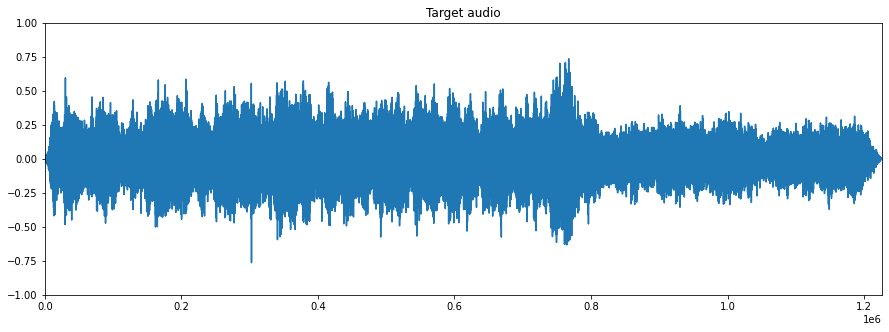

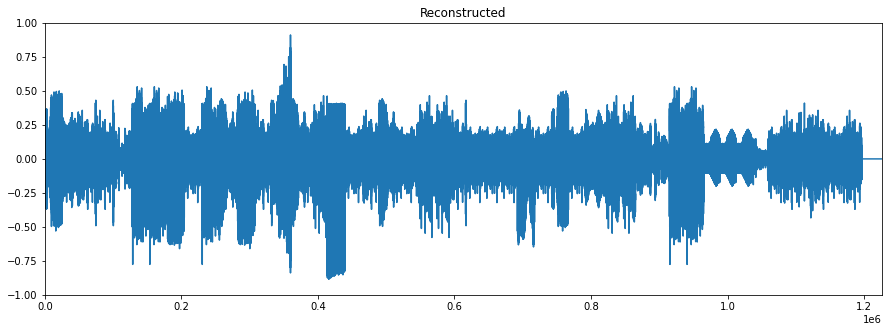

Target audio


Reconstructed


Mix of both signals


In [74]:
# Show further results of the reconstruction

# Plot waveforms
plt.figure(figsize=(15,5))
plt.plot(target_audio)
plt.axis([0, len(target_audio), -1, 1])
plt.title('Target audio')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(generated_audio)
plt.axis([0, len(target_audio), -1, 1])
plt.title('Reconstructed')
plt.show()

# Show audio players
print('Target audio')
display(Audio(target_audio, rate=44100))

print('Reconstructed')
display(Audio(generated_audio, rate=44100))

print('Mix of both signals')
display(Audio(mixed_audio, rate=44100))